# Data Assimialation for the RAMP model using ABC

**VERSION 1. This has notes/tests for how to use ABC to do DA with the RAMP model. Subsequently replaced by [version2](./ramp_da2.ipynb)**

Experiments with whether data assimilation, using ABC, can be used to optimise the model at runtime. 

## Background / motivation

Large uncertaintees in pandemic models
 - who is infected? (uncertainty around testing v.s. real prevalence)
 - when transmission occurs (symptoms / tests play out after the event)
 - interactions (as drivers of transmission) and other behavioural assumptions
 - others?

Parameters evolve
 - new variants influence transmission risk
 - state (etc) interventions influence behaviour
 - human response to interventions changes over time

Difficult to understand true picture of disease spread under these conditions

Opportunity for DA to reduce uncertainties and deal with changes in parameter values

## Approach

 - Use the RAMP model (OpenCL?) to simulate disease spread

 - Feed daily data - on cases?

 - Identify key parameters that should be varied (e.g. behavioural) as the population evolves

## Case study

 - Focus on one area so that specific local policies can be properly modelled. Leeds (Council may be interested) or Devon? (as it works there anyway). Choose Devon initially.

 - Present work as as a proof of concept, i.e. a discussion about what DA can offer these types of models and a case study. 

 - Need to use a relatively simple model (with a simplified state vector) as identifiability will be a big problem. At this stage just focus on varying global parameters

## Data & Methods

Model

 - Very rich representation of individuals. Need to choose a few key (non-individual-level) variables:
   -  proportion of time spent spent doing different activities:
     - shopping, work, schooling (primary & secondary)
   - location hazard multipliers (e.g. vary infectiosness of (types of) places)
   - individual hazard multipliers (e.g. vary infectiosness of disease statuses)
   - (_details on these below, some work has already been done to calibrate them using ABC, e.g. see [abc-2.ipynb](abc-2.ipynb) and [abc-1.ipynb](abc-1.ipynb)).

Data

 - Case data most useful? Available at MSOA
 - Can be downloaded from https://coronavirus.data.gov.uk/details/download 
 - APIs available, e.g.: MSOA case data for Leeds: https://api.coronavirus.data.gov.uk/v2/data?areaType=msoa&areaCode=E08000035&metric=newCasesBySpecimenDateRollingSum&metric=newCasesBySpecimenDateRollingRate&format=csv 

Methods

 - Will assimilating for global variables work? Can you do it without updating the individuals' variables?
 - Start with flat priors rather than a calibrated model. Alternative would be to use initial prior estimates of the paramters that were generated through calibration (e.g. see the bottom of [abc-2.ipynb](abc-2.ipynb)) but more realistic to assume that at the start of a pandemic we don't know what optimised values for these parameters are.
 
## ToDo

[ ] needs doing, [?] Maybe needs doing, [-] in progress, [x] done

 1. [X] Read discussion about seeding on slack and decide how to seed and on which day to start the simulation (good case data only available from April 2020.
         - Hadrian is re-doing the seeding; can use the data that he is creating (from the ONS infection survey?)
         - [ ] Wait for an update so I understand what the new seeding data are.
         - [ ] Work out how these are integrated into the model.

 1. [?] Re-run abc-2.ipynb including presymptomatic and symptomatic multipliers so we have a rough idea about their prior distributions. (May not need to now using flat priors, although there could be value in re-running it using the new code as Fiona has made some changes).
 
 1. [X] Get up-to-date case data by MSOA
 
 1. [X] Implement simple OpenCL model that can step an arbitrary number of times and continue where it left off
 
 1. [X] Get information from this model (while running)
 
 1. [X] Compare model to MSOA case data
   - [ ] Distance function has been implemented, but this needs improving (see notes from discussion with Rory & Hadrian)
 
 1. [X] Test altering the state of this model (while running) -> change a parameter value (disease status to show big increase after N days compared to the baseline?
 
 1. [ ] Use ABC to find the optimal parameters to have given us the observations
 
## Questions / Problems


 - [X] Read paper on the ABC SMC method ("[Simulation-based model selection for dynamical systems in systems and population biology](https://academic.oup.com/bioinformatics/article/26/1/104/182571)")
 
 - [ ] Over longer model runs, how to prevent the parameters from becomming stuck, as the volumne of historical data overwhealm new observations. E.g. ABC will calibrate the model, but wont allow for dynamic parameter updating because the previous x hundred days of data overwhealm any new changes. (Common problem for Bayesian updating?).
 
 - See if anything similar
   - [ ] E.g. Fergusson model used PF for calibration?

## Resources 

 - Paper: [Simulation-based model selection for dynamical systems in systems and population biology](https://academic.oup.com/bioinformatics/article/26/1/104/182571) - uses ABM SMC to do model and parameter selection


## Notes about the existing calibration of the variables

The individual hazards and location hazards were experimented with in [abc-1.ipynb](abc-1.ipynb) and [abc-2.ipynb](abc-2.ipynb) respectively.  Summary of best estimates (priors):

**Individual hazards** 

 - Asymptomatic multiplier (`asymptomatic`)
 
  - This is tricky because we don't know the hazard associated with asymptomatic transmission. James Salter used a prior of: N(0.444, 0.155) which gives the middle 95% as [0.138, 0.75] ([0.138 estimated here](https://www.medrxiv.org/content/10.1101/2020.06.04.20121434v2), [0.58 estimated here](https://jammi.utpjournals.press/doi/abs/10.3138/jammi-2020-0030), [0.75 estimated here (Table 1)](https://www.cdc.gov/coronavirus/2019-ncov/hcp/planning-scenarios.html). 
  
 - Presymptomatic and symptomatic multipliers (`presymptomatic` and `symptomatic`)
  - Uniform between 0 and 1.

**Location hazards:

These are multipliers associated with locations (i.e. make some locations contribute more to the disease risk than others).

 - Home
  - Fixed at 1.0, so all other multipliers are relative to this. This is almost certaintly the most risky activity (i.e. transmission at home is very likely) so no other priors allow values above 1.0.
 - Retail:
  - Uniform between 0 and 1.
 - PrimarySchool: 1.0
  - Uniform between 0 and 1.
 - SecondarySchool: 1.0
  - Uniform between 0 and 1.
 - Work: 1.0
  - Uniform between 0 and 1.


## Import modules

See [abc-1.ipynb](abc-1.ipynb) for notes about installing these libraries

In [1]:
import multiprocessing as mp
import numpy as np
import yaml # pyyaml library for reading the parameters.yml file
import os
import itertools
import pandas as pd
import unittest
import pickle
import copy
import random
import matplotlib.pyplot as plt
import scipy.stats as stats
import plotly.express as px

import pyabc
from pygam import LinearGAM  # For graphing posteriors
from pyabc.transition.multivariatenormal import MultivariateNormalTransition  # For drawing from the posterior

from microsim.initialisation_cache import InitialisationCache
from microsim.opencl.ramp.run import run_headless
from microsim.opencl.ramp.snapshot_convertor import SnapshotConvertor
from microsim.opencl.ramp.snapshot import Snapshot
from microsim.opencl.ramp.params import Params, IndividualHazardMultipliers, LocationHazardMultipliers
from microsim.opencl.ramp.simulator import Simulator
from microsim.opencl.ramp.disease_statuses import DiseaseStatus

# Quieten down the pyopencl info messages (just print errors)
import logging
logging.getLogger("pyopencl").setLevel(logging.ERROR)

import sys
sys.path.append('..')
#import experiments_functions  # For the ones outside the class
from opencl_runner import OpenCLRunner # Some additional notebook-specific functions required (functions.py)

# Set this to False to recalculate all results (good on HPC or whatever). 
# If true then it loads pre-calculated results from pickle files (much quicker)
LOAD_PICKLES = True

# Useful for connecting to this kernel
#%connect_info

## Read case data and spatial data

GIS Data

In [2]:
from microsim.load_msoa_locations import load_osm_shapefile, load_msoa_shapes

gis_data_dir = ("../../devon_data")
#osm_buildings = load_osm_shapefile(gis_data_dir)
devon_msoa_shapes = load_msoa_shapes(gis_data_dir, visualize=False)
devon_msoa_shapes = devon_msoa_shapes.set_index('Code', drop=True, verify_integrity=True)

Loaded 7201 MSOA shapes with projection epsg:27700
Loaded 107 devon MSOA codes
Filtered 107 devon MSOA shapes


Cases data. These were prepared by Hadrien and made available on the RAMP blob storage (see the observation data [README](./observation_data/README.md)).

In [3]:
cases_msoa = pd.read_csv(os.path.join("observation_data", "england_initial_cases_MSOAs.csv")).set_index('MSOA11CD', drop=True, verify_integrity=True)

# Merge them to the GIS data for convenience
cases_msoa = cases_msoa.join(other = devon_msoa_shapes, how="inner")  # Joins on the indices (both indices are MSOA code)
assert len(cases_msoa) == len(devon_msoa_shapes)  # Check we don't use any areas in the join

# For some reason we lose the index name when joining
cases_msoa.index.name = "MSOA11CD"
cases_msoa

,D0,D1,D2,D3,D4,D5,D6,D7,D8,D9,...,objectid,msoa11nm,msoa11nmw,st_area(sh,st_length(,geometry,Easting,Northing,Num,Desc
MSOA11CD,,,,,,,,,,,,,,,,,,,,,
E02004129,0,0,0,0,0,0,0,0,0,0,...,4029,East Devon 001,East Devon 001,1.589055e+08,78853.452613,"POLYGON ((-3.05239 50.90821, -3.05130 50.90635...",319112.091,106067.255,6164,East Devon 001
E02004130,0,0,0,0,0,0,0,0,0,0,...,4030,East Devon 002,East Devon 002,5.595690e+06,16608.909124,"POLYGON ((-3.17191 50.81402, -3.17086 50.81375...",316418.665,100589.954,6232,East Devon 002
E02004131,0,0,0,0,0,0,0,0,0,0,...,4031,East Devon 003,East Devon 003,7.382371e+06,15049.731064,"POLYGON ((-3.20774 50.79940, -3.20636 50.79835...",315676.823,99850.503,6233,East Devon 003
E02004132,0,0,0,0,0,0,0,0,0,0,...,4032,East Devon 004,East Devon 004,1.104563e+08,63961.520903,"POLYGON ((-3.32158 50.85752, -3.31924 50.85695...",309179.725,99451.515,6228,East Devon 004
E02004133,0,0,0,0,0,0,0,0,0,0,...,4033,East Devon 005,East Devon 005,5.164724e+07,46310.010611,"POLYGON ((-2.99660 50.83564, -2.99693 50.83347...",330154.040,98658.412,6230,East Devon 005
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
E02004231,0,0,0,0,0,0,0,0,0,0,...,4131,West Devon 003,West Devon 003,3.631116e+08,144265.307997,"POLYGON ((-3.85341 50.78179, -3.84621 50.78142...",267510.764,89195.616,6259,West Devon 003
E02004232,0,0,0,0,0,0,0,0,0,0,...,4132,West Devon 004,West Devon 004,2.699329e+08,126017.390843,"POLYGON ((-4.18597 50.75767, -4.17707 50.75329...",243289.074,83388.837,6256,West Devon 004
E02004233,0,0,0,0,0,0,0,0,0,0,...,4133,West Devon 005,West Devon 005,1.331482e+07,22485.720797,"POLYGON ((-4.13335 50.57835, -4.12845 50.56881...",248100.775,73943.230,6257,West Devon 005


Map the cases over time to check they look sensible

In [ ]:
# Melt so that cases on each day (D0, D1, ... D404) become a value in a new row
# (Also need to convert the index (area code) to a column)
cases_msoa_melt = pd.melt(cases_msoa.reset_index(), id_vars='MSOA11CD', 
                          value_vars=[ "D"+str(i) for i in range(405) ]).rename(columns={'value':'cases'})

cases_msoa_melt = cases_msoa_melt.loc[1:2000,]  # For testing

cases_msoa_melt['day'] = cases_msoa_melt['variable'].apply(lambda day: int(day[1:])) # Strip off the initial 'D' to get the day number
cases_msoa_melt = cases_msoa_melt.join(devon_msoa_shapes, on="MSOA11CD", how="left")  # Need the geometry from devon shapefile

fig = px.choropleth(cases_msoa_melt, 
              geojson=cases_msoa_melt.geometry.to_json(default_handler=str), 
              locations="MSOA11CD",
              featureidkey="properties.MSOA11CD",
              color="cases", 
              animation_frame="day",
              color_continuous_scale="Inferno",
              title='Cases by MSOA',
              height=400
             )
fig.show()

Function to plot disease status by MSOA for a given timestep and status (useful later)

In [4]:
def plot_msoa_choropleth(msoa_shapes, summary, disease_status, timestep, ax=None):
    """
    """
    # Summary can be a single summary, or a list of a few summaries (will need an average)
    # get dataframes for all statuses
    msoa_data = summary.get_area_dataframes()
    
    msoa_data_for_status = msoa_data[disease_status]

    # add "Code" column so dataframes can be merged
    msoa_data_for_status["Code"] = msoa_data_for_status.index
    msoa_shapes = pd.merge(msoa_shapes, msoa_data_for_status, on="Code")

    msoa_shapes.plot(column=f"Day{timestep}", legend=True, ax=ax)

## Setup Model

Read parameters

In [5]:
PARAMETERS_FILE = os.path.join("..", "..", "model_parameters", "default.yml")
PARAMS = OpenCLRunner.create_parameters(parameters_file=PARAMETERS_FILE)
DATA_DIR = os.path.join("..", "..","devon_data")

/Users/nick/research_not_syncd/git_projects/RAMP-UA/microsim/opencl/ramp/params.py:55: UserWarning: Params object is being created using hard-coded default values, not those in the parameters file.
  warnings.warn("Params object is being created using hard-coded default values, "


Optionally initialise the population, delete the old OpenCL model snapshot (i.e. an already-initialised model) and re-create a new one. Useful if something may have changed (e.g. changed the lockdown file).

Open the (newly created?) snapshot

In [6]:
OPENCL_DIR = "../../microsim/opencl"
SNAPSHOT_FILEPATH = os.path.join(OPENCL_DIR, "snapshots", "cache.npz")
assert os.path.isfile(SNAPSHOT_FILEPATH), f"Snapshot doesn't exist: {SNAPSHOT_FILEPATH}"

Read the real observations (number of hospital admissions in Devon) that will be used to calibrate the model.

Total cases: 16246


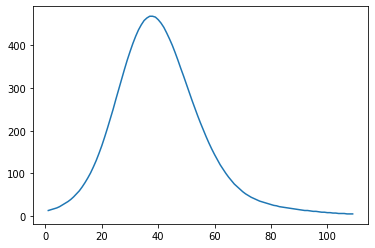

In [7]:
# New per day:
gam_cases = pd.read_csv(os.path.join("..", "..", "gam_cases_new.csv"), header=0, names=["Day", "Cases"], )

# Cumulative
OBSERVATIONS = pd.DataFrame( {"Day": gam_cases['Day'], "Cases": gam_cases.cumsum()['Cases']} )

assert OBSERVATIONS.tail(1)['Cases'].values[0] == sum(gam_cases['Cases'])

plt.plot(gam_cases['Day'], gam_cases['Cases'])
print(f"Total cases: {sum(gam_cases['Cases'])}")

Read the data about the individuals and their locations that are used to create the model (these are stripped down and converted into arrays in the OpenCL model, and it can be useful to have access to the richer, raw data).

In [8]:
# (Code to read the cached individuals and locations do this is in main.py)
cache_dir = os.path.join(DATA_DIR, "caches")
cache = InitialisationCache(cache_dir=cache_dir)
if cache.is_empty():
    raise Error(f"The cache in {cache_dir} has not been initialised. Probably need to run the code a",
                "few cells up that initialises the population")
    
individuals, activity_locations = cache.read_from_cache()

print(f"Activity locations: {activity_locations}")
individuals

Activity locations: {'Home': <Home ActivityLocation>, 'Retail': <Retail ActivityLocation>, 'PrimarySchool': <PrimarySchool ActivityLocation>, 'SecondarySchool': <SecondarySchool ActivityLocation>, 'Work': <Work ActivityLocation>}


,ID,area,_hid,_pid,pid_tus,pid_hse,Sex,age,Age1,Origin,...,Retail_Duration_Initial,PrimarySchool_Duration_Initial,SecondarySchool_Duration_Initial,Work_Duration_Initial,disease_status,status_changed,current_risk,presymp_days,symp_days,exposed_days
0,0,E02004129,7,64.0,150704034,2710265,1,3,1,1,...,0.01389,0.0,0.00000,0.00000,0,False,0,-1,-1,-1
1,1,E02004129,7,6004.0,141711191,2708958,0,84,6,1,...,0.00000,0.0,0.00000,0.00000,0,False,0,-1,-1,-1
2,2,E02004129,46,1408.0,290510172,2710615,1,50,4,1,...,0.01389,0.0,0.00000,0.22917,0,False,0,-1,-1,-1
3,3,E02004129,46,4108.0,110510021,2704823,0,41,3,1,...,0.00000,0.0,0.00000,0.20833,0,False,0,-1,-1,-1
4,4,E02004129,51,496.0,320510093,2705108,1,16,1,1,...,0.00694,0.0,0.28472,0.00000,0,False,0,-1,-1,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
695304,695304,E02004235,26389,55181.0,180202092,2706999,0,65,5,1,...,0.04167,0.0,0.00000,0.00000,0,False,0,-1,-1,-1
695305,695305,E02004235,26393,53730.0,172209011,2703277,0,36,3,1,...,0.03472,0.0,0.00000,0.00000,0,False,0,-1,-1,-1
695306,695306,E02004235,26404,49789.0,182303175,2706380,1,8,1,1,...,0.00000,0.0,0.00000,0.00000,0,False,0,-1,-1,-1
695307,695307,E02004235,26404,51881.0,160109071,2702766,1,66,5,1,...,0.00000,0.0,0.00000,0.34722,0,False,0,-1,-1,-1


### Run the model for N iterations, stop, then continue.

_Basically as a test_

In [9]:
from microsim.opencl.ramp.summary import Summary
from microsim.opencl.ramp.snapshot import Snapshot
from microsim.opencl.ramp.simulator import Simulator
from microsim.opencl.ramp.run import run_headless
from microsim.opencl.ramp.params import Params, IndividualHazardMultipliers, LocationHazardMultipliers
from microsim.opencl.ramp.disease_statuses import DiseaseStatus

from tqdm import tqdm

Run the model for 5 iterations, stop, then continue

In [10]:
QUIET=True
USE_GPU = False
STORE_DETAILED_COUNTS = True
ITERATIONS = 5 # Run for 5 iterations each time
iter_count = 0  # Count the total number of iterations
sim_number=0

# load snapshot
snapshot = Snapshot.load_full_snapshot(path=SNAPSHOT_FILEPATH)

# set params
snapshot.update_params(PARAMS)

# set the random seed of the model for each repetition, otherwise it is completely deterministic
snapshot.seed_prngs(sim_number)

# Create a simulator and upload the snapshot data to the OpenCL device
simulator = Simulator(snapshot, opencl_dir=OPENCL_DIR, gpu=USE_GPU)
simulator.upload_all(snapshot.buffers)

if not QUIET: 
  print(f"Running simulation {sim_number + 1}.")

params = Params.fromarray(snapshot.buffers.params)  # XX Why extract Params? Can't just use PARAMS?

summary = Summary(snapshot, store_detailed_counts=STORE_DETAILED_COUNTS, 
                  max_time=20  # Total length of the simulation
                 )

# only show progress bar in quiet mode
timestep_iterator = range(ITERATIONS) if QUIET else tqdm(range(ITERATIONS), desc="Running simulation")

# Run for iterations days

for _ in timestep_iterator:
    # XX Ask Rory to go through exactly what is happenning here re. uploading and downloading and
    # where the model state is stored.
    # And how the seeding takes place in the Snapshot
    # Update parameters based on lockdown
    params.set_lockdown_multiplier(snapshot.lockdown_multipliers, iter_count)
    simulator.upload("params", params.asarray())

    # Step the simulator
    simulator.step()
    iter_count += 1

    # Update the statuses
    simulator.download("people_statuses", snapshot.buffers.people_statuses)
    summary.update(iter_count, snapshot.buffers.people_statuses)

if not QUIET:
    for i in range(ITERATIONS):
         print(f"\nDay {i}")
         summary.print_counts(i)
        
# Run for another ITERATIONS days

for _ in timestep_iterator:
    # Update parameters based on lockdown
    params.set_lockdown_multiplier(snapshot.lockdown_multipliers, iter_count)
    simulator.upload("params", params.asarray())

    # Step the simulator
    simulator.step()
    iter_count += 1

    # Update the statuses
    simulator.download("people_statuses", snapshot.buffers.people_statuses)
    summary.update(iter_count, snapshot.buffers.people_statuses)



if not QUIET:
    for i in range(ITERATIONS):
         print(f"\nDay {i}")
         summary.print_counts(i)

if not QUIET:
    print("\nFinished")

# Sanity check. The opencl buffers should be the same length as the individuals data frame.
assert len(individuals) == len(snapshot.buffers.people_statuses)

# Download the snapshot from OpenCL to host memory
# XX This is 'None'.
final_state = simulator.download_all(snapshot.buffers)

/Users/nick/research_not_syncd/git_projects/RAMP-UA/microsim/opencl/ramp/params.py:55: UserWarning: Params object is being created using hard-coded default values, not those in the parameters file.
  warnings.warn("Params object is being created using hard-coded default values, "
/Users/nick/research_not_syncd/git_projects/RAMP-UA/microsim/opencl/ramp/params.py:55: UserWarning: Params object is being created using hard-coded default values, not those in the parameters file.
  warnings.warn("Params object is being created using hard-coded default values, "


### See what happened

#### Total number of infections

Text(0, 0.5, 'Number of cases')

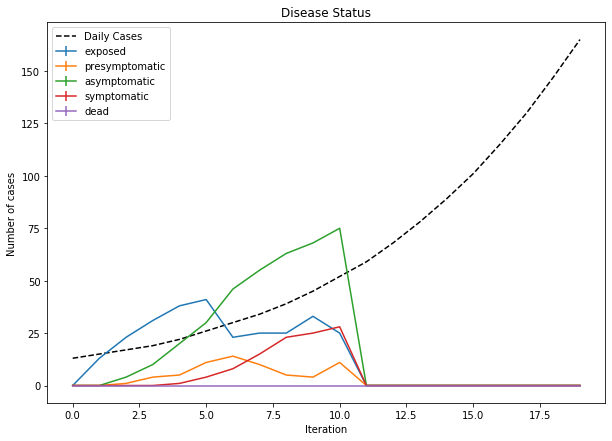

In [11]:
# Lets see what happened: 
fig, ax = plt.subplots(1, 1, figsize=(10,7))
plot_type = "error_bars"
reps=1  # Number of repetitions (1 so far)
iters=len(summary.total_counts[0])  # Total number of iterations
x = range(iters)

for d, disease_status in enumerate(DiseaseStatus):
    if disease_status==DiseaseStatus.Susceptible or disease_status==DiseaseStatus.Recovered:
        continue
    # Calculate the mean and standard deviation
    matrix = np.zeros(shape=(reps,iters))
    if reps==1:  # Only one repetition means a 1-D matrix
        matrix[reps-1] = summary.total_counts[d]
    else:  # Otherwise we ran a load of models, so want to plot lots of summaries
        for rep in range(reps):
            matrix[rep-1] = summaries[rep].total_counts[d]
    mean = np.mean(matrix, axis=0)
    sd = np.std(matrix, axis=0)
    if plot_type == "error_bars":
        ax.errorbar(x, mean, sd, label=f"{disease_status}" )
    elif plot_type == "lines":
        for rep in range(reps):
            ax.plot(x, matrix[rep], label=f"{disease_status} {rep}", 
                    color=plt.cm.get_cmap("hsv", len(DiseaseStatus))(d) )

# Add observation data (subtract 1 because first day is called day '1' but sim starts at 0)
ax.plot(gam_cases.loc[0:iters-1, 'Day']-1, gam_cases.loc[0:iters-1, 'Cases'], '--', color="black", label="Daily Cases")
                
ax.legend() 
ax.set_title("Disease Status")
ax.set_xlabel("Iteration")
ax.set_ylabel("Number of cases")

Check that we can map the diseases (for info)

#### Disease state of individuals

Now find (and later manipulate) the state of the model

_Note: to find out which fields are available in the OpenCL model buffers, do:_
```
print(snapshot.buffers._fields)
```

In [12]:
print(snapshot.buffers._fields)

# Infected individuals

# 'assign' adds a new column called 'Status' which is the numeric status value from the OpenCl buffer, but
# converted into a descriptive disease status by 'map'. ('list' forces map to do the calculation, otherwise it is lazy)
individuals = individuals.assign(Status=list(map(DiseaseStatus, snapshot.buffers.people_statuses)))

# Filter the dataframe on status>0 to get infected individuals
infected_individuals = individuals.loc[snapshot.buffers.people_statuses>0]
print(f"There are {len(infected_individuals)} with disease status > 0")

('place_activities', 'place_coords', 'place_hazards', 'place_counts', 'people_ages', 'people_obesity', 'people_cvd', 'people_diabetes', 'people_blood_pressure', 'people_statuses', 'people_transition_times', 'people_place_ids', 'people_baseline_flows', 'people_flows', 'people_hazards', 'people_prngs', 'params')
There are 145 with disease status > 0


#### Diseases by area

In [13]:
# XX Ask Rory how 'place' is stored in the OpenCL buffers. E.g. does it keep track of MSOA?
# (below we get the MSOA code from the original individuals file)

# Create a dataframe of infected areas (those with any individual with a non-zero disease status).
# (The as_type() converts from a category to avoid areas with 0 counts being included)
infected_areas = infected_individuals.astype({'area': 'str'}).area.value_counts().to_frame('TotalDisease')
# Now add columns for the different disease statuses
for d in DiseaseStatus:
    right_df = individuals.loc[snapshot.buffers.people_statuses==d.value].area.value_counts().to_frame(d)
    infected_areas = infected_areas.merge(right=right_df, left_index=True, right_index=True)

del right_df
infected_areas

,TotalDisease,susceptible,exposed,presymptomatic,asymptomatic,symptomatic,recovered,dead
E02004159,16,9119,0,0,10,4,2,0
E02004157,16,6058,0,2,9,4,1,0
E02004154,13,8121,1,1,8,3,0,0
E02004144,12,6548,0,0,8,4,0,0
E02004149,11,5799,1,0,5,5,0,0
E02004143,10,6091,0,0,6,2,2,0
E02004208,8,7426,0,0,6,2,0,0
E02004156,7,9129,2,1,4,0,0,0
E02004163,6,6506,2,0,3,1,0,0
E02004162,5,6804,0,0,2,2,1,0


### Manipulate state, then keep running 

_Another test_. Will remove all pre-symptomatic infections and see what happens to the disease

In [14]:
# Get the current statuses
simulator.download("people_statuses", snapshot.buffers.people_statuses)

# Remove all exposed, pre-symptomatic, and asymptomatic (set all statuses from 1,2 or 3 to zero, otherwise keep as they are)
f = np.vectorize(lambda x: x if x < 1 or x > 3 else 0)  # (vectorise needed so that the function can be applied to each element)
snapshot.buffers.people_statuses[:] = f(snapshot.buffers.people_statuses)

# Remove all disease (not just pre-symptomatic)
#snapshot.buffers.people_statuses[:] = 0

# Upload the new statuses
simulator.upload_all(snapshot.buffers)
# simulator.upload("people_statuses", f(snapshot.buffers.people_statuses[:]) # (can be used to update just one buffer?)

# Run for a further x days
for _ in range(10):
    # Update parameters based on lockdown
    params.set_lockdown_multiplier(snapshot.lockdown_multipliers, iter_count)
    simulator.upload("params", params.asarray())

    # Step the simulator
    simulator.step()
    iter_count += 1

    # Update the statuses stored in the summary
    simulator.download("people_statuses", snapshot.buffers.people_statuses)
    summary.update(iter_count, snapshot.buffers.people_statuses)
    

if not QUIET:
    for i in range(ITERATIONS):
         print(f"\nDay {i}")
         summary.print_counts(i)

if not QUIET:
    print("\nFinished")

# Sanity check. The opencl buffers should be the same length as the individuals data frame.
assert len(individuals) == len(snapshot.buffers.people_statuses)

Text(0, 0.5, 'Number of cases')

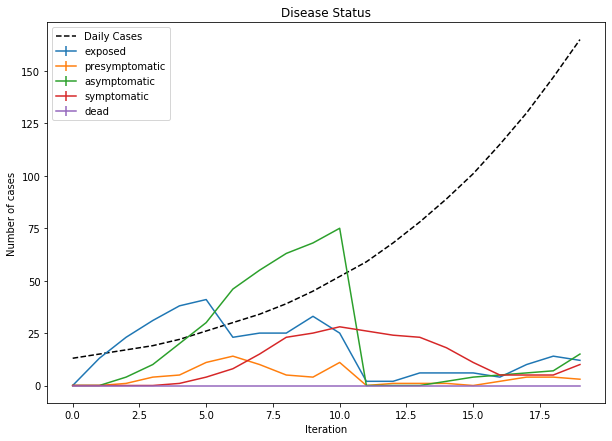

In [15]:
# Lets see what happened: 
fig, ax = plt.subplots(1, 1, figsize=(10,7))
plot_type = "error_bars"
reps=1  # Number of repetitions (1 so far)
iters=len(summary.total_counts[0])  # Total number of iterations
x = range(iters)

for d, disease_status in enumerate(DiseaseStatus):
    if disease_status==DiseaseStatus.Susceptible or disease_status==DiseaseStatus.Recovered:
        continue
    # Calculate the mean and standard deviation
    matrix = np.zeros(shape=(reps,iters))
    if reps==1:  # Only one repetition means a 1-D matrix
        matrix[reps-1] = summary.total_counts[d]
    else:  # Otherwise we ran a load of models, so want to plot lots of summaries
        for rep in range(reps):
            matrix[rep-1] = summaries[rep].total_counts[d]
    mean = np.mean(matrix, axis=0)
    sd = np.std(matrix, axis=0)
    if plot_type == "error_bars":
        ax.errorbar(x, mean, sd, label=f"{disease_status}" )
    elif plot_type == "lines":
        for rep in range(reps):
            ax.plot(x, matrix[rep], label=f"{disease_status} {rep}", 
                    color=plt.cm.get_cmap("hsv", len(DiseaseStatus))(d) )

# Add observation data (subtract 1 because first day is called day '1' but sim starts at 0)
ax.plot(gam_cases.loc[0:iters-1, 'Day']-1, gam_cases.loc[0:iters-1, 'Cases'], '--', color="black", label="Daily Cases")
                
ax.legend() 
ax.set_title("Disease Status")
ax.set_xlabel("Iteration")
ax.set_ylabel("Number of cases")

### Distance function

Need to calculate how well the model is doing on a particular day by comparing the locations of current cases to those in the real case data


In [163]:
# Simulated infections.

# Number of presymptomatic and asymptomatic people per MSOA
cases_per_msoa = individuals.loc[(snapshot.buffers.people_statuses==DiseaseStatus.Presymptomatic.value) | 
                                     (snapshot.buffers.people_statuses==DiseaseStatus.Asymptomatic.value)].area.value_counts().to_frame('CasesSim')
for status, col_name in [ (DiseaseStatus.Presymptomatic.value, "CasesSympSim" ), (DiseaseStatus.Asymptomatic.value, "CasesASympSim") ]:
    cases_per_msoa[col_name] = cases_per_msoa.join(other=individuals.loc[(snapshot.buffers.people_statuses==status)].area.value_counts().to_frame(col_name))[col_name]

# Observed cases (add these to the DF above)
day = iter_count
col = 'D'+str(day-1)  # Name of the column with this day's data

cases_per_msoa['CasesObs'] = cases_per_msoa.join(other=cases_msoa.loc[:,col].to_frame('CasesObs'))['CasesObs']
# Need to estimate how many of these are (pre)symptomatic and asymptomatic
symptomatic_proportion = 0.8
cases_per_msoa['CasesSympObs'] = cases_per_msoa.CasesObs * symptomatic_proportion
cases_per_msoa['CasesASympObs'] = cases_per_msoa.CasesObs * (1-symptomatic_proportion)

In [155]:
def distance(sim, obs):
    """Calculate the distance between the number of cases in the model by MSOA compared to some observations (case data).
    All lists are assumed to be in the same MSOA order (e.g. first element in each list corresponds to the number of cases
    in the same MSOA).
    
    :param sim: Case data per MSOA. A dictionary with two lists: 
      - Symp (number of presymptomatic people in each MSOA in the current day
      - Asymp (number of asymptomatic people in each MSOA in the current day)
    :param obs: Same as `sim`, but have lists have the number of (pre)symptomatic people from real case data
    """
    # For now just do the sum of euclidean distances between presymptomatic and symptomatic cases.
    
    # Check all lists are the same length
    if not ( len(sim['Symp']) == len(sim['Asymp']) == len(obs['Symp']) == len(obs['Asymp']) ):
        raise Exception(f"Lengths should be the same")
    
    symp_difference = np.linalg.norm(np.array(obs['Symp']) - np.array(sim['Symp']))
    pres_difference = np.linalg.norm(np.array(obs['Asymp']) - np.array(sim['Asymp']))
    print(symp_difference, pres_difference)
        
    return symp_difference + pres_difference

# Test it
distance({'Symp': cases_per_msoa['CasesSympSim'], 'Asymp': cases_per_msoa['CasesASympSim']},  # Sim data
         {'Symp': cases_per_msoa['CasesSympObs'], 'Asymp': cases_per_msoa['CasesASympObs']}   # Obs data
        )

24.950350698938085 7.856207736560941


32.80655843549903

## Data Assimilation with the RAMP model

Now that we have all the components, use ABC to do DA on the ramp model ... (see [version2](./ramp_da2.ipynb) of this notebook).